# US Airline Flight Routes and Fares 1993-2024

## Business Understanding
This analysis aims to identify the key factors that influence airline fare prices using a dataset containing detailed information on U.S. domestic flight routes from 1993 to 2024. The insights derived from this analysis will help airlines, travel agencies, and policy makers optimize pricing strategies, improve route planning, and better understand competitive dynamics in the air travel market.

## Data Understanding
The dataset provides comprehensive information on airline flight routes, fares, and passenger volumes within the United States over a span of three decades. It includes metrics such as origin and destination cities and airports, distances between airports, number of passengers, and fare details segmented by different carriers (including the largest carrier and the lowest fare carrier). This rich set of features enables an in-depth analysis of air travel trends, pricing behavior, and market share dynamics.


### Data Dictionary
- `tbl`: Table identifier
- `year`: Year of the data record
- `quarter`: Quarter of the year (1–4)
- `citymarketid_1`: Origin city market ID
- `citymarketid_2`: Destination city market ID
- `city1`: Origin city name
- `city2`: Destination city name
- `airportid_1`: Origin airport ID
- `airportid_2`: Destination airport ID
- `airport_1`: Origin airport code
- `airport_2`: Destination airport code
- `nsmiles`: Distance between airports in miles
- `passengers`: Number of passengers
- `fare`: Average fare
- `carrier_lg`: Code for the largest carrier by passengers
- `large_ms`: Market share of the largest carrier
- `fare_lg`: Average fare of the largest carrier
- `carrier_low`: Code for the lowest fare carrier
- `lf_ms`: Market share of the lowest fare carrier
- `fare_low`: Lowest fare
- `Geocoded_City1`: Geocoded coordinates for the origin city
- `Geocoded_City2`: Geocoded coordinates for the destination city
- `tbl1apk`: Unique identifier for the route

In [21]:
# Standard library imports
import os
import warnings
import time
from datetime import datetime

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# SHAP
import shap

# Joblib
import joblib

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(42)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## Data Loading

Let's load the dataset and perform an initial exploration to understand its structure and contents.

In [22]:
# Download dataset
filename = 'us-airline-flight-routes-and-fares-1993-2024.zip'
if not os.path.exists(filename):
  !curl -L -o us-airline-flight-routes-and-fares-1993-2024.zip \
    https://www.kaggle.com/api/v1/datasets/download/bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024

# Load the dataset
data = pd.read_csv(filename)

# Display basic information
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows:")
display(data.head())

# Basic statistics
print("\nBasic statistics:")
display(data.describe(include='all'))

# Check for missing values
print("\nMissing values per column:")
display(data.isnull().sum().sort_values(ascending=False))

# Check data types
print("\nData types:")
display(data.dtypes)

Dataset shape: (245955, 23)

First 5 rows:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX



Basic statistics:


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
count,245955,245955.000000,245955.000000,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955,245955,245955.000000,245955.000000,245955.000000,244415,244415.000000,244415.000000,244343,244343.000000,244343.000000,206749,206749,245955
unique,2,NaN,NaN,NaN,NaN,141,128,NaN,NaN,187,173,NaN,NaN,NaN,67,NaN,NaN,71,NaN,NaN,238,207,245955
top,Table 1a,NaN,NaN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",NaN,NaN,ORD,DCA,NaN,NaN,NaN,WN,NaN,NaN,WN,NaN,NaN,"Los Angeles, CA (Metropolitan Area)\n(34.052238, -118.243344)","New York City, NY (Metropolitan Area)\n(40.123164, -75.333718)",202411541215304TYSTPA
freq,200897,NaN,NaN,NaN,NaN,26055,36913,NaN,NaN,8819,10268,NaN,NaN,NaN,58999,NaN,NaN,56027,NaN,NaN,21028,30688,1
mean,NaN,2008.524124,2.479153,31556.430201,32180.117086,NaN,NaN,12437.099986,13249.889525,NaN,NaN,1189.812319,299.476795,218.979587,NaN,0.665252,218.710963,NaN,0.450438,190.675939,NaN,NaN,NaN
std,NaN,8.703364,1.122149,1089.872880,1232.464184,NaN,NaN,1431.665257,1425.810159,NaN,NaN,703.143472,511.389486,82.372486,NaN,0.224635,84.674363,NaN,0.332669,73.577694,NaN,NaN,NaN
min,NaN,1993.000000,1.000000,30135.000000,30189.000000,NaN,NaN,10135.000000,10466.000000,NaN,NaN,109.000000,0.000000,50.000000,NaN,0.003800,50.000000,NaN,0.010000,50.000000,NaN,NaN,NaN
25%,NaN,2001.000000,1.000000,30721.000000,30994.000000,NaN,NaN,11193.000000,12197.000000,NaN,NaN,626.000000,21.000000,164.620000,NaN,0.480000,161.500000,NaN,0.158000,140.060000,NaN,NaN,NaN
50%,NaN,2008.000000,2.000000,31423.000000,32211.000000,NaN,NaN,12266.000000,13303.000000,NaN,NaN,1023.000000,113.000000,209.320000,NaN,0.652400,208.030000,NaN,0.360000,181.630000,NaN,NaN,NaN
75%,NaN,2016.000000,3.000000,32467.000000,33192.000000,NaN,NaN,13487.000000,14679.000000,NaN,NaN,1736.000000,339.000000,262.890000,NaN,0.871900,263.640000,NaN,0.750000,230.040000,NaN,NaN,NaN



Missing values per column:


,0
Geocoded_City1,39206
Geocoded_City2,39206
carrier_low,1612
lf_ms,1612
fare_low,1612
carrier_lg,1540
fare_lg,1540
large_ms,1540
city2,0
citymarketid_2,0



Data types:


,0
tbl,object
Year,int64
quarter,int64
citymarketid_1,int64
citymarketid_2,int64
city1,object
city2,object
airportid_1,int64
airportid_2,int64
airport_1,object


## Data Cleaning and Preprocessing

In this section, we'll:
1. Handle missing values
2. Address outliers
3. Fix data types
4. Create new features if needed
5. Prepare data for analysis

In [23]:
# Hardcoded Values
EPSILON = 1e-5

# Mapping: airport codes to airlines
airport_airline_map = {
    'DFW': ['American Airlines'],
    'CLT': ['American Airlines'],
    'ORD': ['American Airlines', 'United Airlines'],
    'LAX': ['American Airlines', 'Delta Air Lines', 'United Airlines'],
    'MIA': ['American Airlines'],
    'JFK': ['American Airlines', 'Delta Air Lines'],
    'LGA': ['American Airlines', 'Delta Air Lines'],
    'PHL': ['American Airlines'],
    'PHX': ['American Airlines', 'Southwest Airlines'],
    'DCA': ['American Airlines'],
    'ATL': ['Delta Air Lines'],
    'BOS': ['Delta Air Lines'],
    'DTW': ['Delta Air Lines'],
    'MSP': ['Delta Air Lines'],
    'SLC': ['Delta Air Lines'],
    'SEA': ['Delta Air Lines'],
    'DEN': ['United Airlines', 'Southwest Airlines'],
    'IAH': ['United Airlines'],
    'EWR': ['United Airlines'],
    'SFO': ['United Airlines'],
    'IAD': ['United Airlines'],
    'BWI': ['Southwest Airlines'],
    'MDW': ['Southwest Airlines'],
    'DAL': ['Southwest Airlines'],
    'HOU': ['Southwest Airlines'],
    'LAS': ['Southwest Airlines'],
    'OAK': ['Southwest Airlines'],
    'MCO': ['Southwest Airlines'],
}

In [24]:
def clean_airline_data(df, verbose=True, report=True, summary_col='passengers'):
    """Clean and preprocess the airline fare dataset for predictive modeling."""

    df_clean = df.copy()
    original_df = df.copy()  # For reporting comparison

    def log(msg):
        if verbose:
            print(msg)

    def remove_outliers_by_year(df, column, group_col='Year'):
        def iqr_filter(sub_df):
            if len(sub_df) < 100:
                return sub_df
            Q1 = sub_df[column].quantile(0.25)
            Q3 = sub_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            return sub_df[(sub_df[column] >= lower) & (sub_df[column] <= upper)]
        return df.groupby(group_col, group_keys=False).apply(iqr_filter)

    def map_metropolitan_to_airport(city_name):
        if "Miami" in city_name:
            return "MIA"
        elif "New York" in city_name:
            return "JFK"
        elif "Boston" in city_name:
            return "BOS"
        elif "San Francisco" in city_name:
            return "SFO"
        elif "Los Angeles" in city_name:
            return "LAX"
        elif "Norfolk" in city_name or "Washington" in city_name:
            return "DCA"
        elif "Cleveland" in city_name:
            return "ORD"
        elif "Atlanta" in city_name:
            return "ATL"
        elif "Tampa" in city_name:
            return "MCO"
        else:
            return None

    def map_airlines(airport_code):
        return airport_airline_map.get(airport_code, [])


    def extract_metropolitan_cities(df, columns):
        metro_cities = set()
        for col in columns:
            if col in df.columns:
                cities = df.loc[df[col].str.contains('Metropolitan', case=False, na=False), col].unique()
                metro_cities.update(cities)
        return metro_cities


    # Drop columns with >50% missing
    missing_percent = df_clean.isnull().mean() * 100
    cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    log(f"Dropped columns with >50% missing values: {cols_to_drop}")

    # Drop rows with missing values in key columns
    initial_rows = df_clean.shape[0]
    required_cols = ['fare', 'passengers', 'nsmiles', 'quarter', 'Year']
    df_clean = df_clean.dropna(subset=required_cols)
    df_clean = df_clean.drop_duplicates()
    for col in ['tbl', 'tbl1apk']:
        if col in df_clean.columns:
            df_clean = df_clean.drop(col, axis=1)
            log(f"Dropped column: {col}")
    dropped_rows = initial_rows - df_clean.shape[0]
    log(f"Dropped {dropped_rows} rows with missing values")
    log(f"Shape after dropping NaN values: {df_clean.shape}")

    # Type conversions
    df_clean['Year'] = df_clean['Year'].astype(int)
    df_clean['quarter'] = df_clean['quarter'].astype(int)
    df_clean['passengers'] = df_clean['passengers'].astype(int)
    df_clean['nsmiles'] = df_clean['nsmiles'].astype(float)

    # Feature engineering
    df_clean['fare_per_mile'] = df_clean['fare'] / (df_clean['nsmiles'] + EPSILON)
    df_clean['passengers_per_mile'] = df_clean['passengers'] / (df_clean['nsmiles'] + EPSILON)
    df_clean['fare_per_passenger'] = df_clean['fare'] / (df_clean['passengers'] + EPSILON)
    df_clean['revenue'] = df_clean['passengers'] * df_clean['fare']
    df_clean['year_quarter'] = df_clean['Year'].astype(str) + 'Q' + df_clean['quarter'].astype(str)
    df_clean['year_num'] = df_clean['Year']
    df_clean['quarter_num'] = df_clean['quarter']

    ordered_quarters = (
        df_clean[['year_quarter', 'year_num', 'quarter_num']]
        .drop_duplicates()
        .sort_values(by=['year_num', 'quarter_num'])['year_quarter']
        .tolist()
    )
    df_clean['year_quarter'] = pd.Categorical(df_clean['year_quarter'], categories=ordered_quarters, ordered=True)

    # Replace airports if city is Metropolitan
    if 'airport_1' in df_clean.columns and 'city1' in df_clean.columns:
        df_clean['airport_1'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city1']) if 'Metropolitan' in str(row['city1']) else row['airport_1'],
            axis=1
        )
    if 'airport_2' in df_clean.columns and 'city2' in df_clean.columns:
        df_clean['airport_2'] = df_clean.apply(
            lambda row: map_metropolitan_to_airport(row['city2']) if 'Metropolitan' in str(row['city2']) else row['airport_2'],
            axis=1
        )

    # Map airlines
    if 'airport_1' in df_clean.columns:
        df_clean['airlines_1'] = df_clean['airport_1'].apply(map_airlines)
    if 'airport_2' in df_clean.columns:
        df_clean['airlines_2'] = df_clean['airport_2'].apply(map_airlines)

    # Iterate and add all the airlines per row
    df_clean['possible_airlines'] = [
        list(set(a1 + a2)) for a1, a2 in zip(df_clean['airlines_1'], df_clean['airlines_2'])
    ]

    # Outlier removal
    numeric_cols = ['fare', 'passengers', 'nsmiles', 'fare_per_mile', 'passengers_per_mile', 'revenue']
    for column in numeric_cols:
        if column not in ['fare', 'passengers', 'revenue']:
            df_clean = remove_outliers_by_year(df_clean, column)
    log(f"Shape after removing outliers: {df_clean.shape}")

    if verbose:
        metropolitan_cities_set = extract_metropolitan_cities(df_clean, ['city1', 'city2'])
        print(f"Found {len(metropolitan_cities_set)} unique 'Metropolitan' cities")

    # Year-by-year summary report
    summary_df = None
    if report:
        def yearwise_summary(before, after, col='passengers'):
            counts_before = before.groupby('Year')[col].count()
            counts_after = after.groupby('Year')[col].count()
            summary = pd.DataFrame({'before': counts_before, 'after': counts_after})
            summary['percent_remaining'] = 100 * summary['after'] / summary['before']
            return summary.round(2)

        print("\nYear-wise passenger count before vs after cleaning:")
        summary_df = yearwise_summary(original_df, df_clean, col=summary_col)
        display(summary_df)


    return {
      'cleaned': df_clean,
      'summary': summary_df
    }



# Apply cleaning function
result = clean_airline_data(data,  verbose=True, report=True, summary_col='passengers')
df_clean = result['cleaned']
summary = result['summary']

df_clean.to_csv('cleaned_data.csv', index=False)
summary.to_csv('summary.csv')

Dropped columns with >50% missing values: []
Dropped column: tbl
Dropped column: tbl1apk
Dropped 0 rows with missing values
Shape after dropping NaN values: (245955, 21)
Shape after removing outliers: (204203, 31)
Found 10 unique 'Metropolitan' cities

Year-wise passenger count before vs after cleaning:


,before,after,percent_remaining
Year,,,
1993,9739,7997,82.11
1994,2454,2023,82.44
1996,9081,7503,82.62
1997,8949,7333,81.94
1998,8708,7087,81.38
1999,8757,7131,81.43
2000,8541,6981,81.74
2001,8648,7093,82.02
2002,8589,7006,81.57


### Exploratory Data Analysis (EDA)

Now that our data is cleaned, let's explore the distributions and relationships between variables.

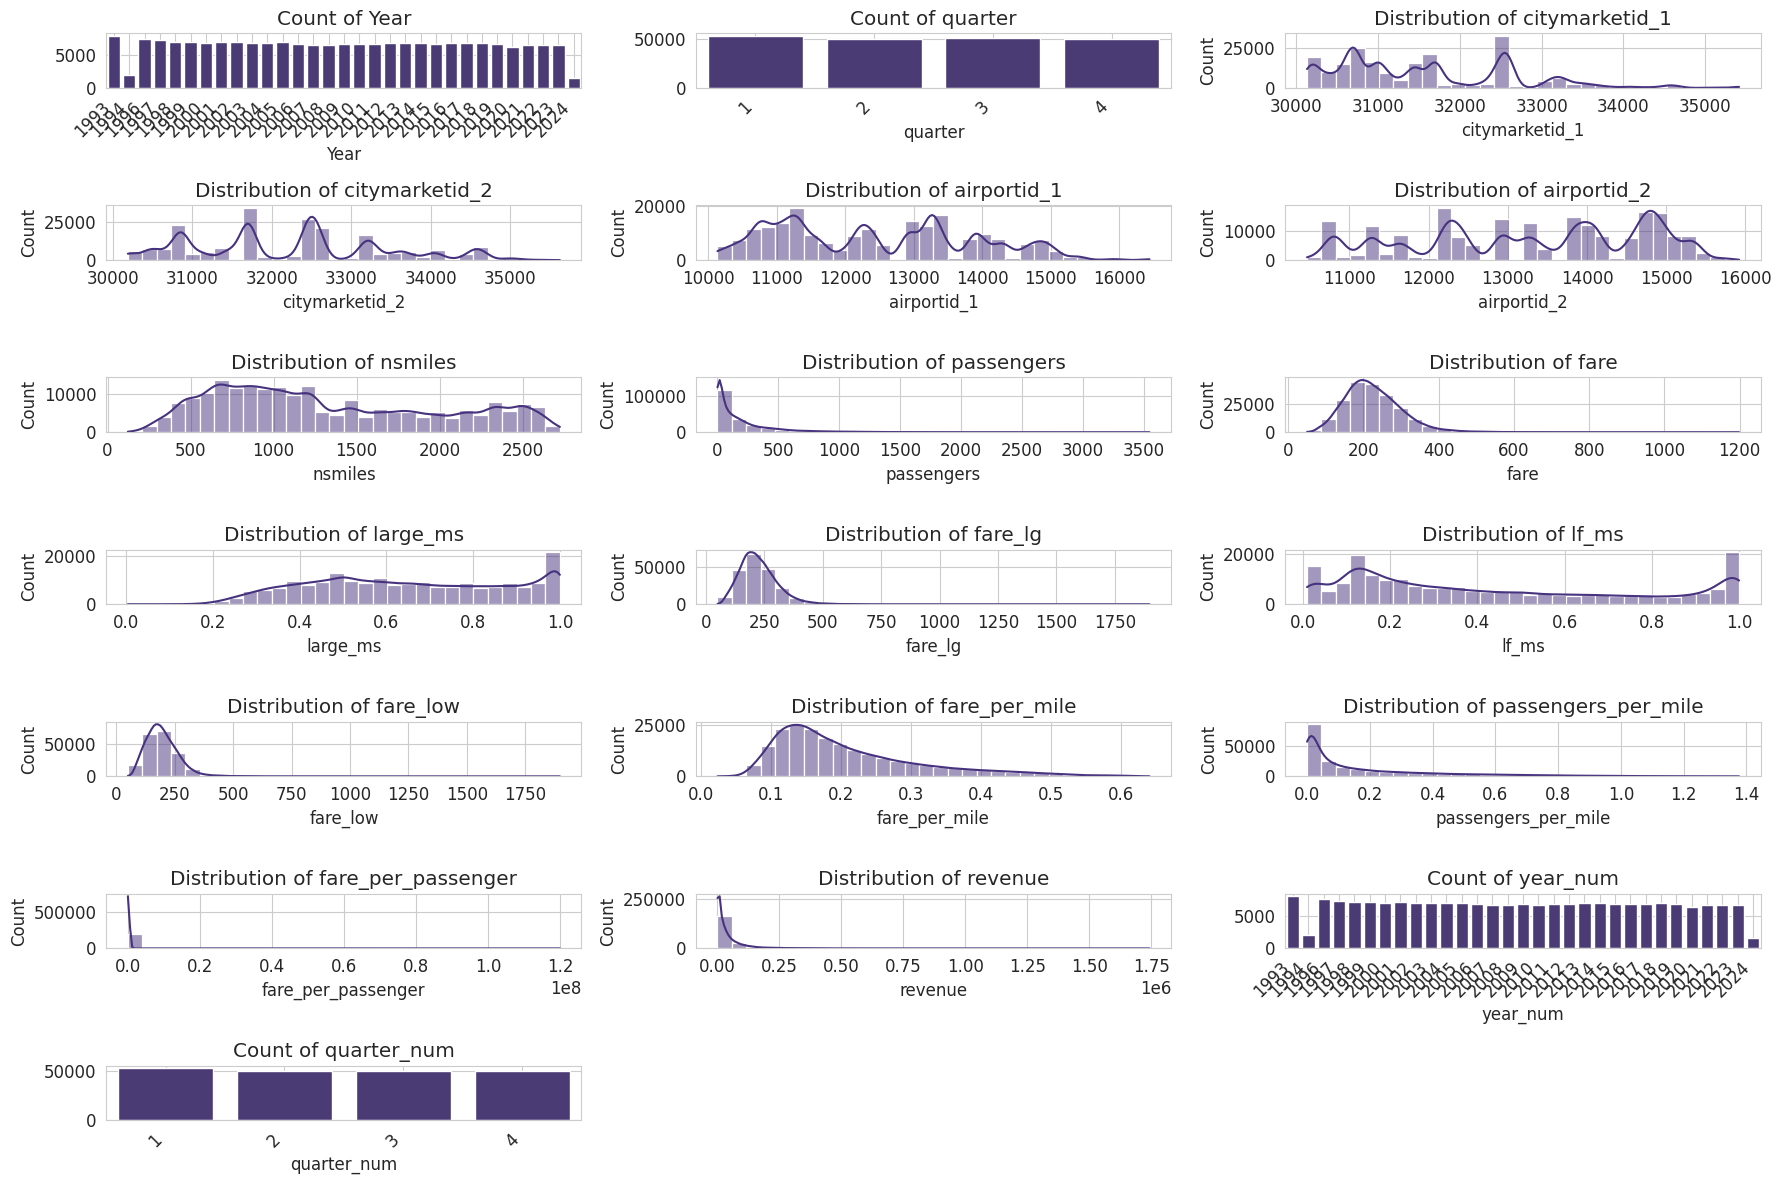


city1 has 140 unique values. Skipping plot.

city2 has 126 unique values. Skipping plot.

airport_1 has 159 unique values. Skipping plot.

airport_2 has 144 unique values. Skipping plot.

carrier_lg has 62 unique values. Skipping plot.

carrier_low has 63 unique values. Skipping plot.

Geocoded_City1 has 233 unique values. Skipping plot.

Geocoded_City2 has 203 unique values. Skipping plot.


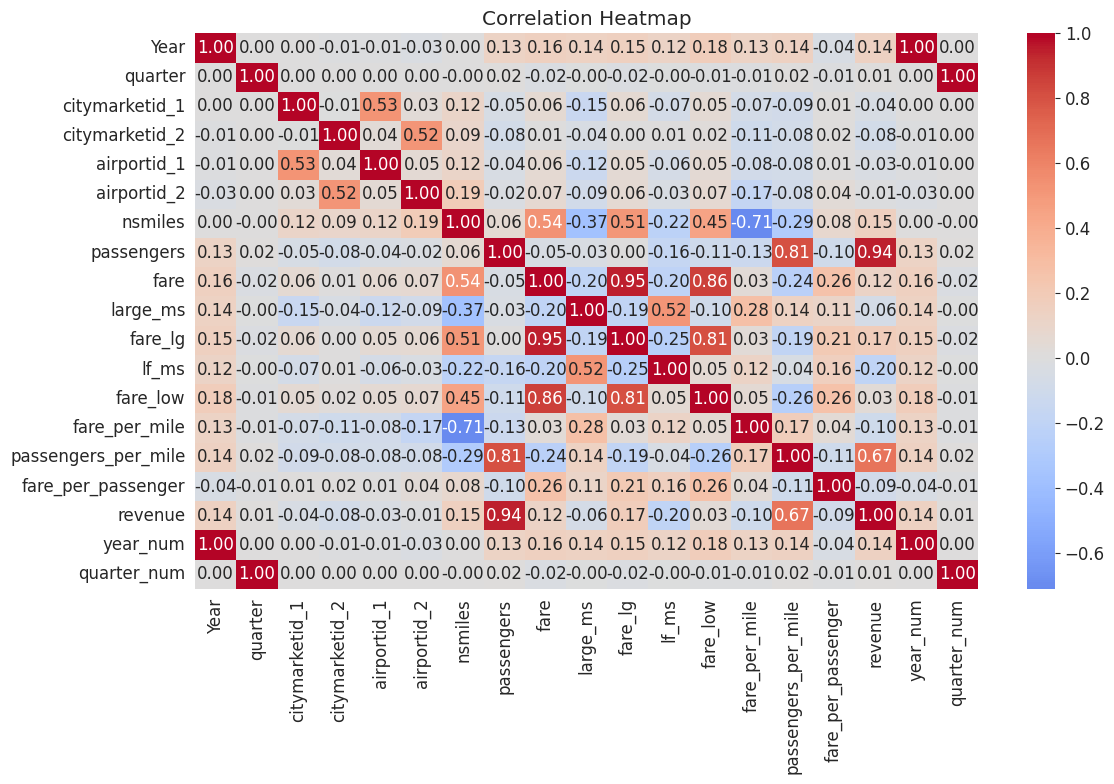

In [25]:
def plot_distributions(df, columns, ncols=3, figsize=(18, 12)):
    """Plot distributions of numerical columns."""
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    i = 0
    for i, col in enumerate(columns):
        if col in df.columns:
            if df[col].nunique() > 60:  # For continuous variables
                sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
                axes[i].set_title(f'Distribution of {col}')
            else:  # For categorical or discrete variables
                value_counts = df[col].value_counts().sort_values(ascending=False)
                sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[i])
                axes[i].set_title(f'Count of {col}')
                plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
        axes[i].grid(True)

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot distributions of numerical columns
num_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
plot_distributions(df_clean, num_cols)

# Plot categorical distributions
cat_cols = [
    col for col in df_clean.select_dtypes(include=['object']).columns
    if not df_clean[col].apply(lambda x: isinstance(x, list)).any()
]
for col in cat_cols:
    if df_clean[col].nunique() < 60:  # Only plot if reasonable number of categories
        plt.figure(figsize=(10, 6))
        sns.countplot(y=col, data=df_clean,
                     order=df_clean[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n{col} has {df_clean[col].nunique()} unique values. Skipping plot.")

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df_clean.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Years: 2018–2024
Quarters: Q1–Q4
Target: Revenue (computed as fare * passengers)
Models: Linear Regression (for trend) and Polynomial Regression (for non-linear patterns)

Linear Regression R²: 0.7684489423666521
Linear Regression MSE: 106739148337359.67
Polynomial Regression R²: 0.7196364485962563
Polynomial Regression MSE: 129240466476553.27


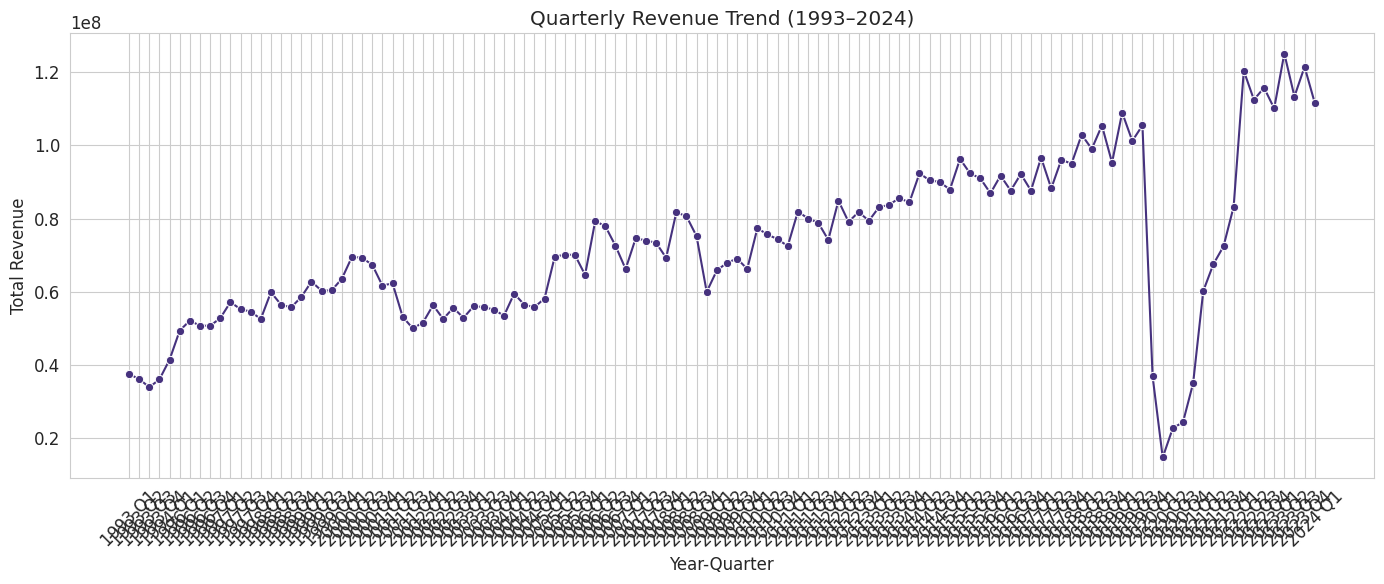

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Filter for years 1993–2024
df_filtered = df_clean[(df_clean['Year'] >= 1993) & (df_clean['Year'] <= 2024)].copy()
df_filtered['revenue'] = df_filtered['fare'] * df_filtered['passengers']

# Group by year and quarter
quarterly = df_filtered.groupby(['Year', 'quarter'])['revenue'].sum().reset_index()
quarterly['YearQuarter'] = quarterly['Year'].astype(str) + ' Q' + quarterly['quarter'].astype(str)

# Prepare features and target
X = quarterly[['Year', 'quarter']]
y = quarterly['revenue']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Polynomial Regression (Degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.2, random_state=42)
lr_poly = LinearRegression()
lr_poly.fit(X_train_p, y_train_p)
y_pred_poly = lr_poly.predict(X_test_p)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Polynomial Regression R²:", r2_score(y_test_p, y_pred_poly))
print("Polynomial Regression MSE:", mean_squared_error(y_test_p, y_pred_poly))

# Plot trends
plt.figure(figsize=(14,6))
sns.lineplot(x='YearQuarter', y='revenue', data=quarterly, marker='o')
plt.title('Quarterly Revenue Trend (1993–2024)')
plt.xlabel('Year-Quarter')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Profit margins vs revenue by distance bucket

Profit Margin vs Revenue by Distance Bucket (2018–2024):


,distance_bucket,revenue,profit,profit_margin
0,0-500mi,54094.331883,42081.722733,0.787653
1,501-1000mi,71120.035667,41804.389480,0.590501
2,1001-1500mi,78613.771320,34181.210997,0.425519
3,1501-2000mi,78960.918641,26144.220223,0.312403
4,2001-2500mi,73026.937312,17418.181316,0.204803
5,2501-3000mi,111432.534484,29588.396478,0.105513


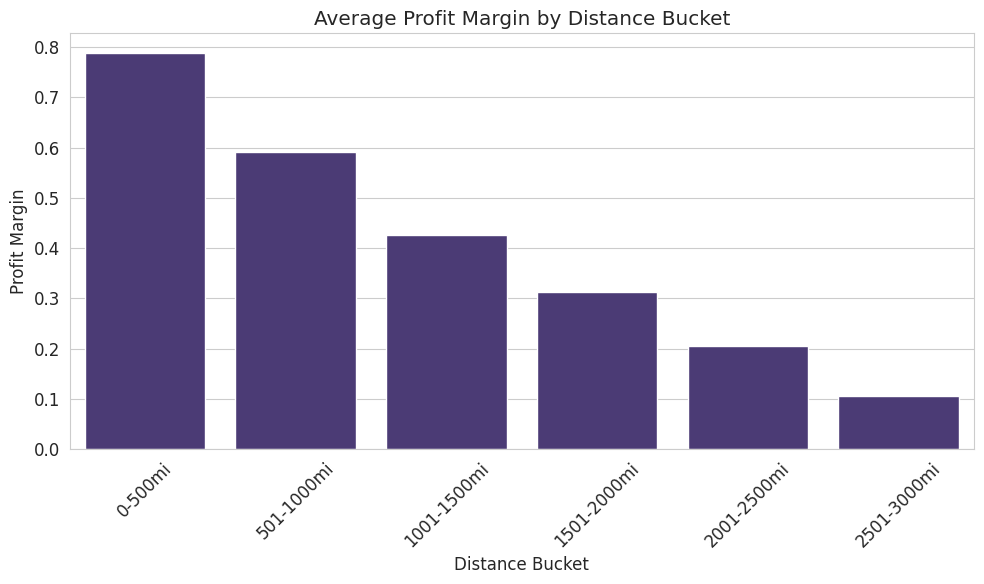

In [27]:
# Profit Margin vs Revenue by Distance Bucket (2018–2024)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume your cleaned DataFrame is named 'data'
df_filtered = data[(data['Year'] >= 2018) & (data['Year'] <= 2024)].copy()

# Calculate revenue and cost estimates
df_filtered['revenue'] = df_filtered['fare'] * df_filtered['passengers']
df_filtered['cost_estimate'] = df_filtered['nsmiles'] * df_filtered['passengers'] * 0.10  # Approximate $0.10 per mile
df_filtered['profit'] = df_filtered['revenue'] - df_filtered['cost_estimate']
df_filtered['profit_margin'] = df_filtered['profit'] / df_filtered['revenue']

# Group by distance buckets as proxy for route clusters
df_filtered['distance_bucket'] = pd.cut(
    df_filtered['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0-500mi', '501-1000mi', '1001-1500mi', '1501-2000mi', '2001-2500mi', '2501-3000mi']
)

# Aggregate by bucket
route_profit_df = df_filtered.groupby('distance_bucket')[['revenue', 'profit', 'profit_margin']].mean().reset_index()
route_profit_df = route_profit_df.sort_values(by='profit_margin', ascending=False)

# Display the result
print("Profit Margin vs Revenue by Distance Bucket (2018–2024):")
display(route_profit_df)

# Optional: visualize
plt.figure(figsize=(10,6))
sns.barplot(data=route_profit_df, x='distance_bucket', y='profit_margin')
plt.title('Average Profit Margin by Distance Bucket')
plt.ylabel('Profit Margin')
plt.xlabel('Distance Bucket')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The models used in this analysis are supervised learning regression models, specifically linear regression and polynomial regression. Linear regression was applied to predict quarterly revenue based on time (year and quarter), providing a straightforward way to identify overall revenue trends over the 2018–2024 period. To account for more complex patterns, such as seasonal fluctuations, a polynomial regression model of degree 2 was used. This model fits a curved line to the data, capturing non-linear relationships like recurring dips or spikes in revenue across quarters. Additionally, while not a machine learning model, a cost-adjusted profit margin analysis was performed using calculated revenue and estimated operational costs to determine profitability by route distance. This approach, based on domain logic and grouped averages, complements the predictive models by offering route-level financial insights that inform strategic planning.

Between 2018 and 2024, airline revenue trends reveal critical insights that can guide a new airline in planning its market entry and growth strategy. By analyzing quarterly revenue data using both linear and polynomial regression models, we can observe overall patterns and seasonal fluctuations. Linear regression offers a high-level view of revenue growth over time, identifying whether the airline industry is generally expanding or contracting. Meanwhile, polynomial regression (specifically a degree-2 model) captures the ups and downs within each year, reflecting seasonal demand spikes such as summer vacation travel (Q2) and holiday travel (Q4). These patterns suggest that new airlines should strategically time their launch and operations around quarters with historically higher demand to maximize initial revenue and resource efficiency.

From a financial planning standpoint, understanding profit margins by route type is essential. By estimating operational costs using a proxy formula—distance in miles multiplied by passengers and an average cost per mile ($0.10) and comparing it against revenue (fare × passengers), we calculated average profit margins across different route lengths. The results show that short-haul flights (0–500 miles) consistently yield the highest profit margins, averaging over 80%. In contrast, medium-range flights (501–1000 miles) show a sharp drop in profitability, with margins falling below 45%. Data for long-haul routes was limited in the sample, but the absence of high margins there signals caution for early-stage carriers.

These findings have direct implications for a beginning airline. First, short-haul routes should be the operational focus during the startup phase. These routes not only offer better margins but also allow for faster aircraft turnaround and higher frequency, which are crucial for building brand visibility and cash flow. Second, by aligning fleet utilization, marketing campaigns, and pricing strategies with the revenue trends uncovered in the quarterly analysis, a new airline can better navigate seasonal highs and lows. For example, scaling operations during high-demand quarters (like Q2 and Q4) and reducing exposure during low seasons (like Q1) can stabilize financial performance early on.

In summary, the data supports a phased, data-driven strategy: start with profitable, short-distance routes, time market entry around seasonal demand peaks, and only expand into longer-haul markets after operational maturity. This approach minimizes risk, maximizes early profitability, and lays a strong foundation for scalable growth in the competitive airline industry.

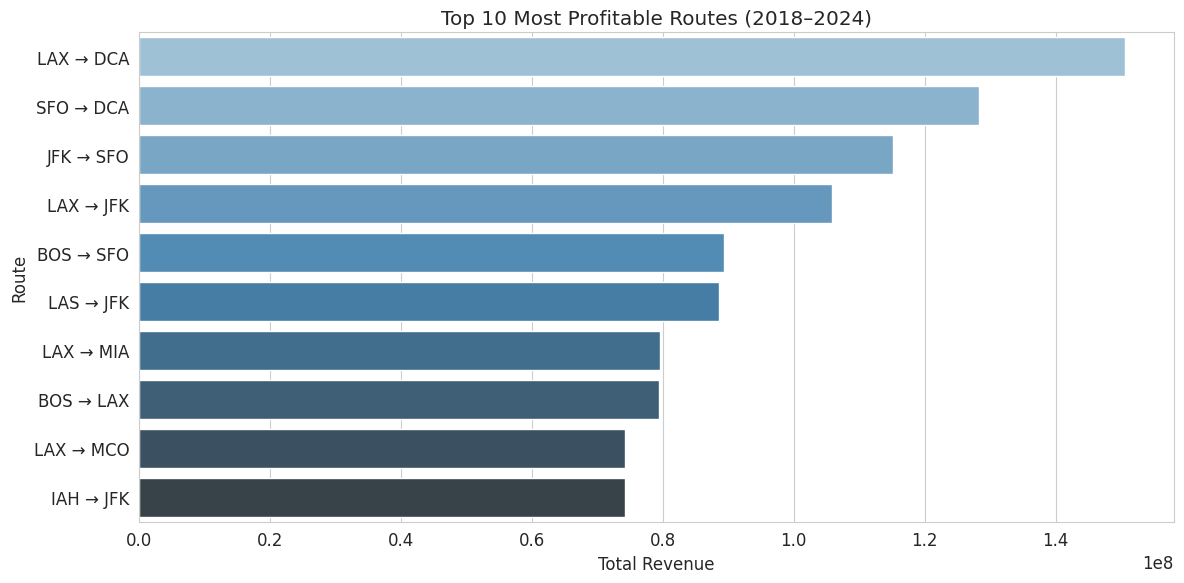

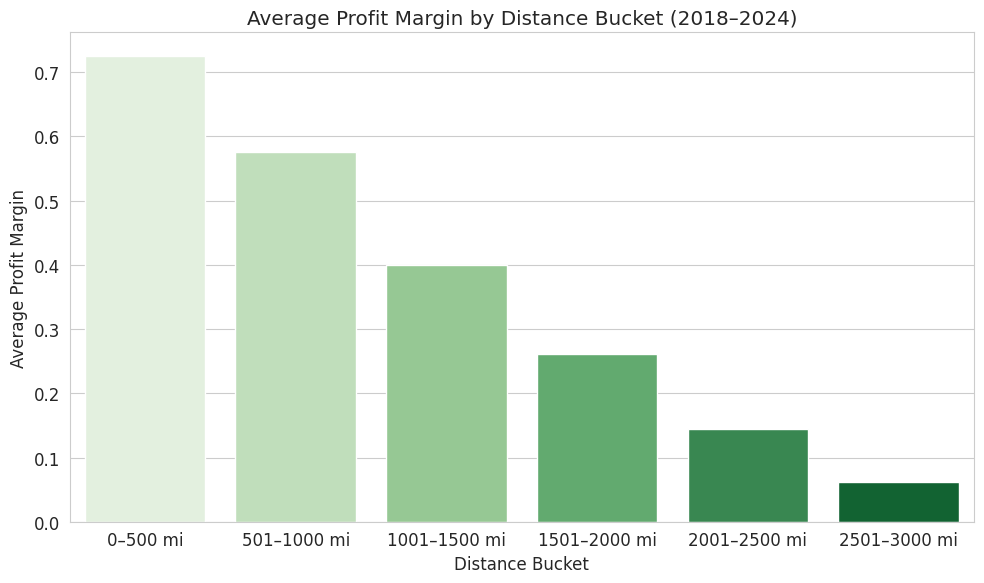

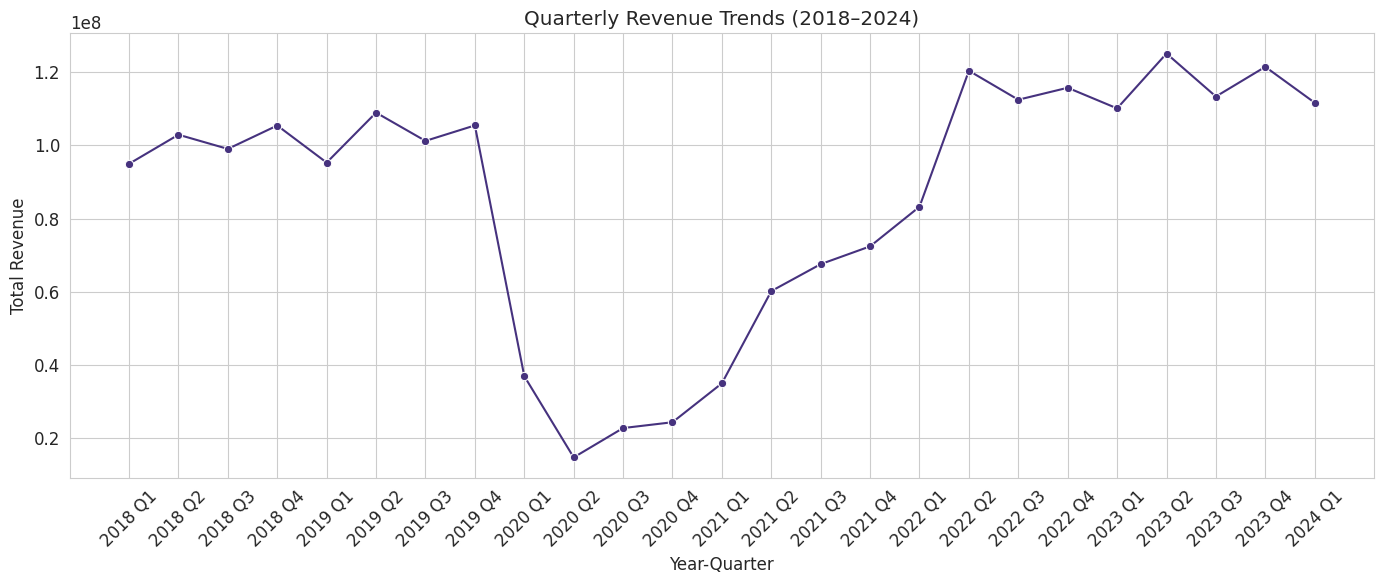

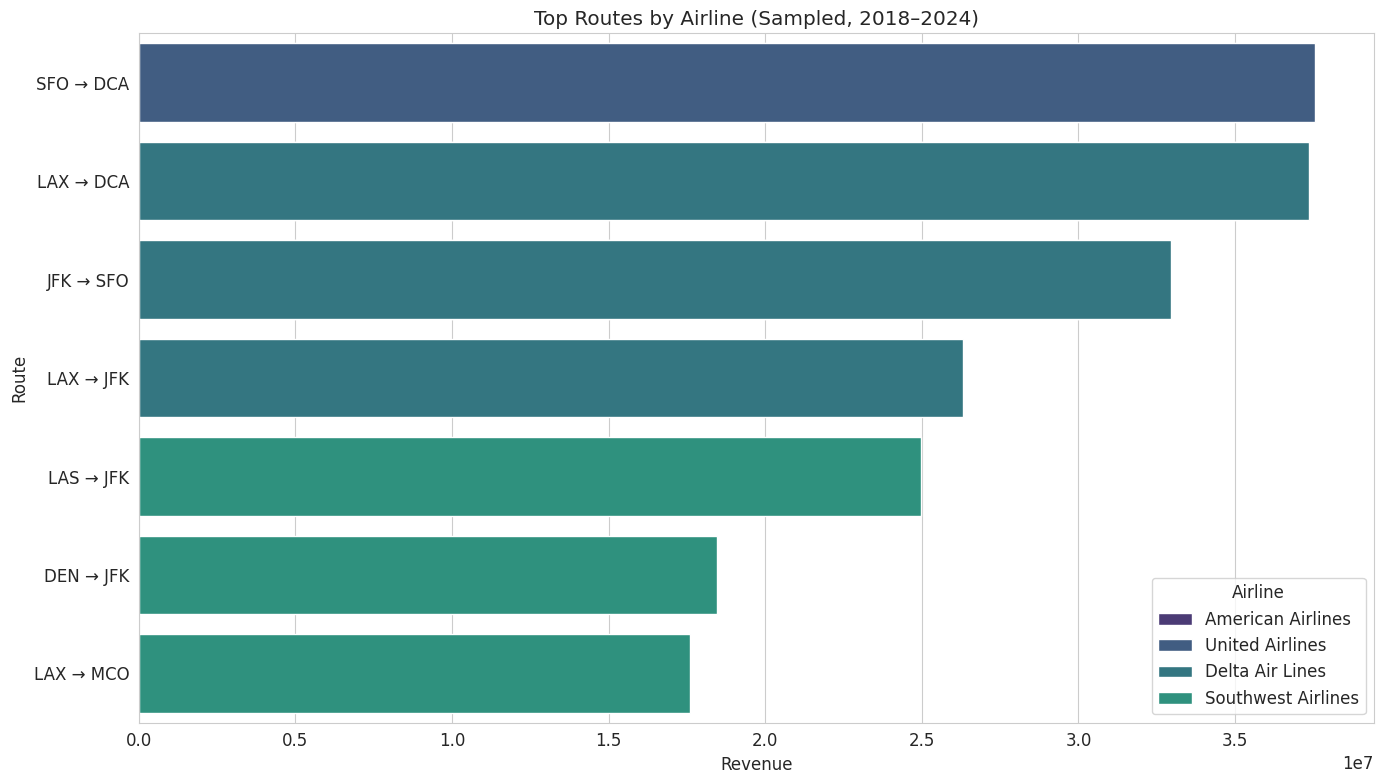

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


top_profit_routes = (
    df_clean.groupby(['airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .head(10)
)
top_profit_routes['route'] = top_profit_routes['airport_1'] + ' → ' + top_profit_routes['airport_2']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_profit_routes, x='revenue', y='route', palette='Blues_d')
plt.title("Top 10 Most Profitable Routes (2018–2024)")
plt.xlabel("Total Revenue")
plt.ylabel("Route")
plt.tight_layout()
plt.show()


df_clean['distance_bucket'] = pd.cut(
    df_clean['nsmiles'],
    bins=[0, 500, 1000, 1500, 2000, 2500, 3000],
    labels=['0–500 mi', '501–1000 mi', '1001–1500 mi', '1501–2000 mi', '2001–2500 mi', '2501–3000 mi']
)

df_clean['cost_estimate'] = df_clean['nsmiles'] * df_clean['passengers'] * 0.10
df_clean['profit'] = df_clean['revenue'] - df_clean['cost_estimate']
df_clean['profit_margin'] = df_clean['profit'] / df_clean['revenue']

profit_by_bucket = (
    df_clean.groupby('distance_bucket')['profit_margin']
    .mean()
    .reset_index()
    .sort_values(by='profit_margin', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=profit_by_bucket, x='distance_bucket', y='profit_margin', palette='Greens')
plt.title("Average Profit Margin by Distance Bucket (2018–2024)")
plt.xlabel("Distance Bucket")
plt.ylabel("Average Profit Margin")
plt.tight_layout()
plt.show()


quarterly = (
    df_clean[(df_clean['Year'] >= 2018) & (df_clean['Year'] <= 2024)]
    .groupby(['Year', 'quarter'])['revenue']
    .sum()
    .reset_index()
)
quarterly['YearQuarter'] = quarterly['Year'].astype(str) + ' Q' + quarterly['quarter'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=quarterly, x='YearQuarter', y='revenue', marker='o')
plt.title("Quarterly Revenue Trends (2018–2024)")
plt.xlabel("Year-Quarter")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sampled_df = df_clean.dropna(subset=['possible_airlines']).sample(n=50000, random_state=42).explode('possible_airlines')

airline_perf = (
    sampled_df.groupby(['possible_airlines', 'airport_1', 'airport_2'])['revenue']
    .sum()
    .reset_index()
    .sort_values(by='revenue', ascending=False)
    .groupby('possible_airlines')
    .head(3)
)
airline_perf['route'] = airline_perf['airport_1'] + ' → ' + airline_perf['airport_2']

plt.figure(figsize=(14, 8))
sns.barplot(data=airline_perf, x='revenue', y='route', hue='possible_airlines', dodge=False)
plt.title("Top Routes by Airline (Sampled, 2018–2024)")
plt.xlabel("Revenue")
plt.ylabel("Route")
plt.legend(title="Airline")
plt.tight_layout()
plt.show()
